In [1]:
!pip install gymnasium pygame tensorboard
!pip install swig
!pip install "gymnasium[box2d]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp312-cp312-linux_x86_64.whl size=2399053 sha256=d9f8e90391d9717f8012bbcd83620912bce8b22c80abfa41e9be81ad23debe13
  Stored in directory: /root/.cache/pip/wheels/2a/e9/60/774da0bcd07f7dc7761a8590fa2d065e4069568e78dcdc3318
Successfully built box2d-py


In [4]:
import gymnasium as gym
import numpy as np
import random
import math
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import imageio

# ============================================================
# 1. Hyperparameters
# ============================================================
ENV_ID = "LunarLander-v3"

SEED = 0
GAMMA = 0.99
LR = 3e-4

LEARNING_STARTS = 10_000
TRAIN_FREQ = 4

BATCH_SIZE = 64
REPLAY_CAPACITY = 100_000

TARGET_UPDATE_FREQ = 1000
MAX_EPISODES = 2000
MAX_STEPS_PER_EPISODE = 1000

EPSILON_START = 1.0
EPSILON_END = 0.1
EPSILON_DECAY_FRAMES = 150_000

HIDDEN_UNITS = 128

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Transition = namedtuple("Transition", ("state", "action", "reward", "next_state", "done"))


# ============================================================
# 2. Replay Buffer
# ============================================================
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def append(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


# ============================================================
# 3. Neural Network (DQN)
# ============================================================
class DQN(nn.Module):
    def __init__(self, in_states, hidden_units, out_actions):
        super().__init__()
        self.fc1 = nn.Linear(in_states, hidden_units)
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        self.out = nn.Linear(hidden_units, out_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)


# ============================================================
# 4. Epsilon-Greedy Policy
# ============================================================
def get_epsilon(frame_idx):
    eps = EPSILON_START - (frame_idx * (EPSILON_START - EPSILON_END) / EPSILON_DECAY_FRAMES)
    return max(EPSILON_END, eps)


def select_action(policy_net, state, epsilon, n_actions):
    if random.random() < epsilon:
        return random.randrange(n_actions)
    else:
        s = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
        with torch.no_grad():
            q = policy_net(s)
        return int(q.argmax(dim=1).item())


# ============================================================
# 5. Double DQN Optimization Step
# ============================================================
def optimize_model(memory, policy_net, target_net, optimizer):
    if len(memory) < BATCH_SIZE:
        return None

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    state_batch = torch.tensor(np.array(batch.state), dtype=torch.float32, device=DEVICE)
    action_batch = torch.tensor(batch.action, dtype=torch.int64, device=DEVICE).unsqueeze(1)
    reward_batch = torch.tensor(batch.reward, dtype=torch.float32, device=DEVICE)
    next_state_batch = torch.tensor(np.array(batch.next_state), dtype=torch.float32, device=DEVICE)
    done_batch = torch.tensor(batch.done, dtype=torch.float32, device=DEVICE)

    q_values = policy_net(state_batch).gather(1, action_batch).squeeze(1)

    # Double DQN target computation
    with torch.no_grad():
        next_actions_online = policy_net(next_state_batch).argmax(dim=1)
        next_q_target = target_net(next_state_batch).gather(
            1, next_actions_online.unsqueeze(1)
        ).squeeze(1)

        expected_q = reward_batch + GAMMA * next_q_target * (1.0 - done_batch)

    loss = F.smooth_l1_loss(q_values, expected_q)

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(policy_net.parameters(), 10.0)
    optimizer.step()

    return loss.item()

def adjust_lr(optimizer, episode):
    if episode < 600:
        lr = 3e-4
    elif episode < 1200:
        lr = 2e-4
    else:
        lr = 1e-4

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


# ============================================================
# 6. Training Loop (CONSOLE LOGGING ONLY)
# ============================================================
def train():
    env = gym.make(
        ENV_ID,
        continuous=False,
        gravity=-10.0,
        enable_wind=False,
        wind_power=15.0,
        turbulence_power=1.5,
        render_mode="rgb_array"
    )

    env.reset(seed=SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)

    obs, _ = env.reset()
    n_states = env.observation_space.shape[0]
    n_actions = env.action_space.n

    policy_net = DQN(n_states, HIDDEN_UNITS, n_actions).to(DEVICE)
    target_net = DQN(n_states, HIDDEN_UNITS, n_actions).to(DEVICE)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=LR)
    memory = ReplayMemory(REPLAY_CAPACITY)

    frame_idx = 0
    reward_history = []

    for episode in range(1, MAX_EPISODES + 1):
        state, _ = env.reset()
        ep_reward = 0

        # adjust_lr(optimizer, episode)
        # framesforvideo = []

        for step in range(MAX_STEPS_PER_EPISODE):
            frame_idx += 1
            epsilon = get_epsilon(frame_idx)

            action = select_action(policy_net, state, epsilon, n_actions)

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # if episode == 1 or episode % 100 == 0:
            #   framesforvideo.append(env.render())

            memory.append(state, action, reward, next_state, float(done))

            state = next_state
            ep_reward += reward

            # loss = optimize_model(memory, policy_net, target_net, optimizer)

            if frame_idx > LEARNING_STARTS and frame_idx % TRAIN_FREQ == 0:
              loss = optimize_model(memory, policy_net, target_net, optimizer)
              # soft update for target here, not at every step
              tau = 0.005
              for target_param, param in zip(target_net.parameters(), policy_net.parameters()):
                  target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

            # if frame_idx % TARGET_UPDATE_FREQ == 0:
            #     target_net.load_state_dict(policy_net.state_dict())   #Old code - target = policy after certain frame

            # tau = 0.005
            # for target_param, param in zip(target_net.parameters(), policy_net.parameters()):
            #   target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data) #at every step smoothly

            if done:
                break


        reward_history.append(ep_reward)

        # if episode == 1 or episode % 100 == 0:
        #   imageio.mimsave(f"lander_{episode}.gif", framesforvideo, fps=30)

        # Console logging every 10 episodes
        if episode % 10 == 0:
            avg100 = np.mean(reward_history[-100:])
            print(
                f"Episode {episode:4d} | "
                f"Reward: {ep_reward:7.2f} | "
                f"Avg100: {avg100:7.2f} | "
                f"Epsilon: {epsilon:.3f}"
            )

        # Stop condition
        if len(reward_history) >= 100 and np.mean(reward_history[-100:]) > 250:
            print(f"Solved in {episode} episodes!")
            break

    env.close()
    return policy_net, reward_history

def plot_training(rewards):
    plt.figure(figsize=(12,5))
    plt.title("Episode rewards")
    plt.plot(rewards, label="episode reward")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.tight_layout()
    plt.show()

def evaluate(policy_net, episodes=5, render=True):
    env = gym.make(
        ENV_ID,
        continuous=False,
        gravity=-10.0,
        enable_wind=False,
        wind_power=15.0,
        turbulence_power=1.5,
        render_mode="human" if render else None
    )
    reward_history = []
    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            s = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
            with torch.no_grad():
                action = policy_net(s).argmax(dim=1).item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            state = next_state

        print(f"[Eval] Episode {ep+1}: Reward = {total_reward:.2f}")
        reward_history.append(total_reward)

    env.close()
    return reward_history

Episode   10 | Reward: -358.09 | Avg100: -173.16 | Epsilon: 0.994
Episode   20 | Reward:  -47.71 | Avg100: -159.54 | Epsilon: 0.988
Episode   30 | Reward: -108.81 | Avg100: -153.82 | Epsilon: 0.983
Episode   40 | Reward: -180.42 | Avg100: -162.70 | Epsilon: 0.977
Episode   50 | Reward: -323.78 | Avg100: -169.24 | Epsilon: 0.972
Episode   60 | Reward: -262.81 | Avg100: -172.18 | Epsilon: 0.966
Episode   70 | Reward: -108.11 | Avg100: -174.50 | Epsilon: 0.960
Episode   80 | Reward: -349.04 | Avg100: -181.74 | Epsilon: 0.954
Episode   90 | Reward: -227.07 | Avg100: -183.17 | Epsilon: 0.947
Episode  100 | Reward: -409.61 | Avg100: -182.32 | Epsilon: 0.942
Episode  110 | Reward:  -99.09 | Avg100: -185.17 | Epsilon: 0.936
Episode  120 | Reward:  -91.21 | Avg100: -186.67 | Epsilon: 0.931
Episode  130 | Reward:  -96.41 | Avg100: -185.30 | Epsilon: 0.925
Episode  140 | Reward: -249.78 | Avg100: -183.07 | Epsilon: 0.919
Episode  150 | Reward: -180.01 | Avg100: -175.96 | Epsilon: 0.913
Episode  1

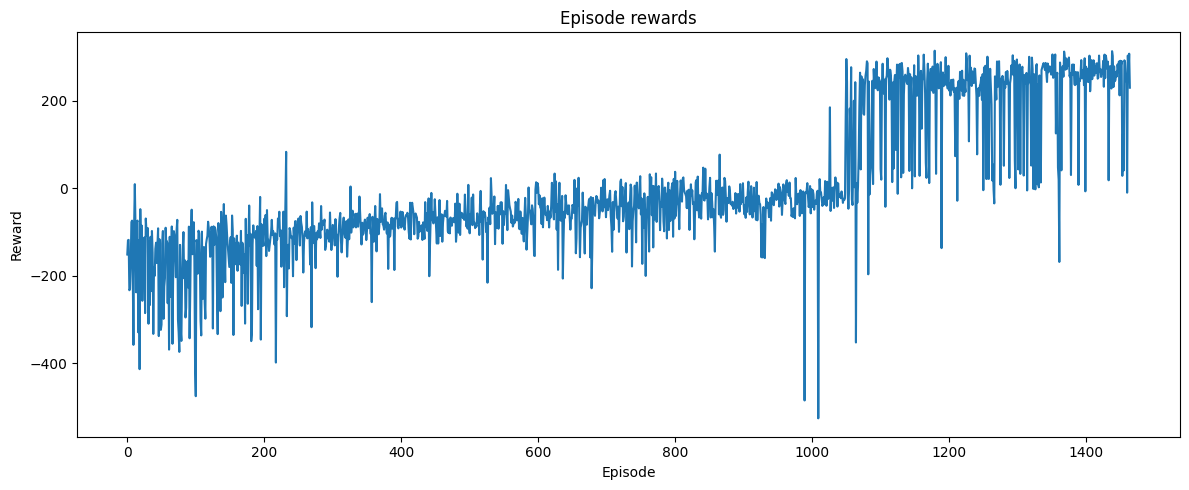

Model loaded successfully.


In [ ]:
# For training, uncomment below lines
policy, history = train()
torch.save(policy.state_dict(), "dqn_lander.pth")
print("Saved model as dqn_lander.pth")
plot_training(rewards=history)

print("Model loaded successfully.")

In [ ]:
evaluate(policy, episodes=5, render=True)

[Eval] Episode 1: Reward = 255.89
[Eval] Episode 2: Reward = 227.34
[Eval] Episode 3: Reward = 134.99
[Eval] Episode 4: Reward = 230.43
[Eval] Episode 5: Reward = 250.57


In [8]:
# For using a trained model, use below
n_states = 8
n_actions = 4
hidden_units = 128
policy_evaluated = DQN(n_states, hidden_units, n_actions).to(DEVICE)
policy_evaluated.load_state_dict(torch.load("Optimized_Policy_2.pth", map_location=DEVICE))
policy_evaluated.eval()

DQN(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=4, bias=True)
)

[Eval] Episode 1: Reward = 195.05
[Eval] Episode 2: Reward = 263.89
[Eval] Episode 3: Reward = 267.39
[Eval] Episode 4: Reward = 258.94
[Eval] Episode 5: Reward = 253.51
[Eval] Episode 6: Reward = 219.93
[Eval] Episode 7: Reward = 250.04
[Eval] Episode 8: Reward = 215.92
[Eval] Episode 9: Reward = 33.00
[Eval] Episode 10: Reward = 274.96
[Eval] Episode 11: Reward = 205.90
[Eval] Episode 12: Reward = 252.67
[Eval] Episode 13: Reward = 169.56
[Eval] Episode 14: Reward = 259.40
[Eval] Episode 15: Reward = 187.24
[Eval] Episode 16: Reward = 237.84
[Eval] Episode 17: Reward = 236.09
[Eval] Episode 18: Reward = 286.81
[Eval] Episode 19: Reward = 263.35
[Eval] Episode 20: Reward = 263.16
[Eval] Episode 21: Reward = 248.75
[Eval] Episode 22: Reward = 252.07
[Eval] Episode 23: Reward = 262.37
[Eval] Episode 24: Reward = 250.07
[Eval] Episode 25: Reward = 219.33
[Eval] Episode 26: Reward = 235.98
[Eval] Episode 27: Reward = 271.88
[Eval] Episode 28: Reward = 185.88
[Eval] Episode 29: Reward = 27

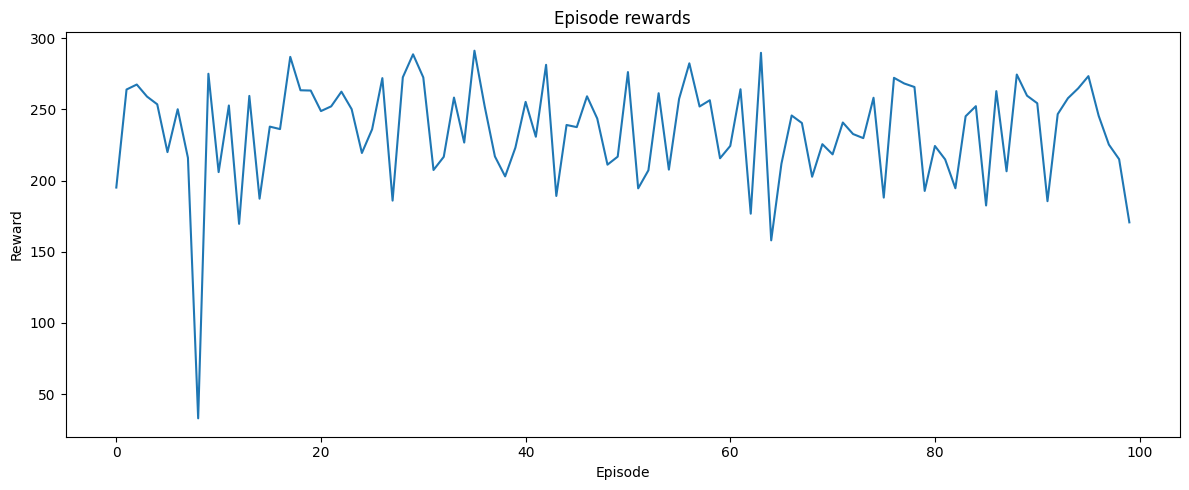

In [10]:
hist = evaluate(policy_evaluated, episodes=100, render=True)
plot_training(rewards=hist)

In [ ]:
def evaluateSingle(policy_net, render=True):
    env = gym.make(
        ENV_ID,
        continuous=False,
        gravity=-10.0,
        enable_wind=False,
        wind_power=15.0,
        turbulence_power=1.5,
        render_mode="rgb_array" if render else None
    )

    state, _ = env.reset()
    done = False
    total_reward = 0
    frames = []

    while not done:
        s = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
        with torch.no_grad():
            action = policy_net(s).argmax(dim=1).item()

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        frames.append(env.render())
        total_reward += reward
        state = next_state
        print(f"[Next State] - ({state[0]},{state[1]},{state[2]}), Left: {state[6]} | Right: {state[7]} Reward = {total_reward:.2f}")

    print(f"[Eval] Reward = {total_reward:.2f}")

    env.close()

    return frames

In [ ]:
frames = evaluateSingle(policy)
imageio.mimsave("lander_Evaluation5.gif", frames, fps=30)

[Next State] - (-0.003925800323486328,1.4302871227264404,-0.19855812191963196), Left: 0.0 | Right: 0.0 Reward = 1.18
[Next State] - (-0.005888938903808594,1.4390825033187866,-0.198565274477005), Left: 0.0 | Right: 0.0 Reward = 2.47
[Next State] - (-0.00785217247903347,1.4472779035568237,-0.1985718458890915), Left: 0.0 | Right: 0.0 Reward = 3.79
[Next State] - (-0.009815406985580921,1.4548733234405518,-0.19857841730117798), Left: 0.0 | Right: 0.0 Reward = 5.12
[Next State] - (-0.011778640560805798,1.4618688821792603,-0.19858500361442566), Left: 0.0 | Right: 0.0 Reward = 6.47
[Next State] - (-0.01374206505715847,1.4682643413543701,-0.19859156012535095), Left: 0.0 | Right: 0.0 Reward = 7.83
[Next State] - (-0.015705585479736328,1.4740599393844604,-0.19859810173511505), Left: 0.0 | Right: 0.0 Reward = 9.17
[Next State] - (-0.017669105902314186,1.4792554378509521,-0.19860461354255676), Left: 0.0 | Right: 0.0 Reward = 10.50
[Next State] - (-0.019632721319794655,1.4838509559631348,-0.19861112